In [1]:
import os
import sys
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.spatial import distance
from math import sqrt
import random
import mpl_toolkits.mplot3d.axes3d as p3

In [2]:
def load_plot_data(root, img_name):
    # Load image as Image object and convert to grayscale.
    I1 = Image.open(root + img_name + '1.jpg').convert('L')
    I2 = Image.open(root + img_name + '2.jpg').convert('L')

    # Load matches.
    # this is a N x 4 file where the first two numbers of each row
    # are coordinates of corners in the first image and the last two
    # are coordinates of corresponding corners in the second image: 
    # matches(i,1:2) is a point in the first image
    # matches(i,3:4) is a corresponding point in the second image
    matches = np.loadtxt(root + img_name + '_matches.txt')

    # Display two images side-by-side with matches.
    I3 = np.zeros((I1.size[1],I1.size[0]*2) )
    I3[:,:I1.size[0]] = I1;
    I3[:,I1.size[0]:] = I2;
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(np.array(I3).astype(float), cmap='gray')
    ax.plot(matches[:,0],matches[:,1],  '+r')
    ax.plot(matches[:,2]+I1.size[0],matches[:,3], '+r')
    ax.plot([matches[:,0], matches[:,2]+I1.size[0]],[matches[:,1], matches[:,3]], 
            'r', linewidth=0.3)
    plt.axis('off')
    plt.savefig(root+'outputs/'+img_name+'_matches.svg', format='svg')
    plt.show()

    # Return Image object as numpy array.
    I1_arr = np.array(I1)
    I2_arr = np.array(I2)

    return I1_arr, I2_arr, matches

In [3]:
def plot_epipolar(matches, F, I2_arr, root, name):
    """Display second image with epipolar lines reprojected 
    from the first image."""

    # first, fit fundamental matrix to the matches
    # F = fit_fundamental(matches); # this is a function that you should write
    N = len(matches)
    M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
    L1 = np.matmul(F, M).transpose() # transform points from 
    # the first image to get epipolar lines in the second image

    # find points on epipolar lines L closest to matches(:,3:4)
    l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
    L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
    pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
    closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())

    # find endpoints of segment on epipolar line (for display purposes)
    pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10# offset from the closest point is 10 pixels
    pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10

    # display points and segments of corresponding epipolar lines
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(np.array(I2_arr).astype(float), cmap='gray')
    ax.plot(matches[:,2],matches[:,3], 'or', markersize=2)
    ax.plot([matches[:,2], closest_pt[:,0]],[matches[:,3], closest_pt[:,1]], 'r')
    ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g', linewidth=1)
    plt.axis('off')
    plt.savefig(root+'outputs/'+name+'.svg', format='svg')
    plt.show()

In [4]:
def sift_descriptors(img):
    """Helper function for get_matched_pixels().
    Find keypoints and descriptors using SIFT.
    Note that img must be grayscale and in CV_8U type, because
    the SIFT funciton only accept this (not double precision)
    """
    
    print("Finding keypoints and descriptors...")
    # Larger threshold (contrastThreshold=0.07) eliminates weak features.
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints, desp = sift.detectAndCompute(img,None)
    return keypoints, desp

In [5]:
def get_matched_pixels(threshold, kp1, kp2, desp1, desp2):
    """Find matching descriptors using Euclidean distance.
    
    Args:
        threshold(float): To select matched pairs.
        kp1, kp2(KeyPoint structure): Keypoints of two images.
        desp1, desp2(numpy.ndarray): descriptors, dims (#keypoints, 128).
    Returns:
        match_coords(numpy.ndarray): Coordinates of the matched pixels in 
            pairs, dims (#matched pixels, 4), where each row is in the 
            form of [x1, y1, x2, y2]
    """
    
    print("Matching features...")
    # Pair distance with shape (desp1.shape[0], desp2.shape[0]).
    pair_dist = distance.cdist(desp1, desp2, 'sqeuclidean')
    # Get matched descriptors.
    desp1_idx = np.where(pair_dist < threshold)[0]
    desp2_idx = np.where(pair_dist < threshold)[1]
    # Find the corresponding keypoint coordinates.
    coord1 = np.array([kp1[idx].pt for idx in desp1_idx])
    coord2 = np.array([kp2[idx].pt for idx in desp2_idx])
    match_coords = np.concatenate((coord1, coord2), axis=1)

    return match_coords

In [6]:
def fit_fundamental(matches, normalize=False, setup='homogeneous'):
    """Fit fundamental matrix using eight-point alg.
    
    Args:
        matches: Coords of pairs in image 1 and 2, dims (#matches, 4).
        normalize: Boolean flag for using normalized or unnormalized alg.
        setup(str): 'homogeneous' or 'non-homogeneous' setup for solving 
            linear systems.
    Returns:
        F: Fundamental matrix, dims (3, 3).
    """
    # print("Fitting fundamental...")
    all_p1 = matches[:, 0:2]  # All points of image1 in matching pairs.
    all_p2 = matches[:, 2:4]  # All points of image2 in matching pairs.

    # Normalize data.
    if normalize:
        all_p1, T1 = normalization(all_p1)
        all_p2, T2 = normalization(all_p2)

    # Randomly sample 8 matching pairs (unique).
    rand_idx = random.sample(range(matches.shape[0]), k=8)
    select_p1 = all_p1[rand_idx]
    select_p2 = all_p2[rand_idx]

    # Esitimate F.
    F = solve_linear_sys(select_p1, select_p2, setup)

    # Transform F back to original units (denormalize).
    if normalize:
        F = np.dot(np.dot(T2.T, F), T1)
    
    return F

In [7]:
def get_geo_distance(matches, F):
    """Compute average geometric distances between epipolar line and its 
    corresponding point in both images. Note that matches is all of the 
    matching pair, not the selected ones in fit_fundamental()."""

    ones = np.ones((matches.shape[0], 1))
    all_p1 = np.concatenate((matches[:, 0:2], ones), axis=1)
    all_p2 = np.concatenate((matches[:, 2:4], ones), axis=1)
    # Epipolar lines.
    F_p1 = np.dot(F, all_p1.T).T  # F*p1, dims [#points, 3].
    F_p2 = np.dot(F.T, all_p2.T).T  # (F^T)*p2, dims [#points, 3].
    # Geometric distances.
    p1_line2 = np.sum(all_p1 * F_p2, axis=1)[:, np.newaxis]
    p2_line1 = np.sum(all_p2 * F_p1, axis=1)[:, np.newaxis]
    d1 = np.absolute(p1_line2) / np.linalg.norm(F_p2, axis=1)[:, np.newaxis]
    d2 = np.absolute(p2_line1) / np.linalg.norm(F_p1, axis=1)[:, np.newaxis]

    # Final distance.
    dist1 = d1.sum() / matches.shape[0]
    dist2 = d2.sum() / matches.shape[0]

    return dist1, dist2

In [8]:
def normalization(points):
    """Helper function to normalized data in image."""
    # De-mean to center the origin at mean.
    mean = np.mean(points, axis=0)
    # Rescale.
    std_x = np.std(points[:, 0])
    std_y = np.std(points[:, 1])

    # tmp1 = points[:,0]-mean[0]
    # tmp2 = points[:,1]-mean[1]
    # dist = np.sqrt(tmp1**2+tmp2**2)
    # scale = sqrt(2)/np.mean(dist)
    
    # Matrix for transforming points to do normalization.
    transform = np.array([[sqrt(2)/std_x, 0, -sqrt(2)/std_x*mean[0]], 
                          [0, sqrt(2)/std_y, -sqrt(2)/std_y*mean[1]], 
                          [0, 0, 1]])
    # transform = np.array([[scale, 0, -scale*mean[0]], 
    #                       [0, scale, -scale*mean[1]], 
    #                       [0, 0, 1]])
    # Homogeneous coords.
    points = np.concatenate((points, np.ones((points.shape[0], 1))), axis=1)
    normalized = np.dot(transform, points.T).T

    return normalized[:, 0:2], transform

In [9]:
def solve_linear_sys(pairs_p1, pairs_p2, setup):
    """Use 8 pairs to solve linear system to get F,
    with either 'homogeneous' or 'non-homogeneous' setup.
    """
    A_rows = []  # Every row in A is a sublist of A_row.
    
    # Construct A.
    for i in range(pairs_p1.shape[0]):
        p1 = pairs_p1[i]
        p2 = pairs_p2[i]
        
        row = [p2[0]*p1[0], p2[0]*p1[1], p2[0], 
               p2[1]*p1[0], p2[1]*p1[1], p2[1], p1[0], p1[1], 1]
        A_rows.append(row)

    A = np.array(A_rows)

    # Solve linear system.
    if setup == 'homogeneous':
        U, s, V = np.linalg.svd(A)
        F = V[len(V)-1].reshape(3, 3)
        # Normalize F to homogeneous coords.
        F = F / F[2, 2] 
    elif setup == 'non-homogeneous':
        A = A[:, 0:8]  # A is now in dims [8, 8]
        F = np.linalg.solve(A, np.ones(A.shape[1])*(-1))
        F = np.append(F, 1).reshape(3, 3)

    # Enforce rank-2 constraint.
    U, s, Vh = np.linalg.svd(F)
    s_prime = np.diag(s)
    s_prime[-1] = 0
    F = np.dot(U, np.dot(s_prime, Vh))

    return F

In [10]:
def ransac_fitting(match_coords, threshold):
    """Eliminate outliers and fit the homography using RANSAC alg.
    
    Args:
        match_coords(numpy.ndarray): In dims (#matched pixels, 4).
        threshold(float): For determining inliers.
    Returns:
        best_inliers(numpy.ndarray): In dims (#inliers, 4).
        best_F(numpy.ndarray): Fundamental matrix, dims (3, 3).
        avg_residual(float): Average esidual for all inliers. 
    """
    print("Performing RANSAC...")

    max_ite = 1000
    ite = 0

    num_inliers = 0
    num_best_inliers = 0

    # RANSAC procedure.
    while ite < max_ite:

        # Randomly select 4 matched pairs (unique).
        # rand_idx = random.sample(range(match_coords.shape[0]), k=4)
        # select_pairs = match_coords[rand_idx]

        # Fit a homography.
        # H = fit_homography(select_pairs)
        F = fit_fundamental(match_coords, normalize=True)

        # # Jump to next loop if H is degenerate.
        # if np.linalg.matrix_rank(H) < 3:
        #     continue

        # Find and add inliers.
        errors = get_errors(match_coords, F)
        idx = np.where(errors < threshold)[0]
        inliers = match_coords[idx]

        # Save current solution and compute residual if it's the best.
        num_inliers = len(inliers)
        if num_inliers > num_best_inliers:
            best_inliers = inliers.copy()
            num_best_inliers = num_inliers
            best_F = F.copy()
            
            avg_residual = errors[idx].sum() / num_best_inliers

        ite += 1
    
    # print("Number of inliers: {}, Average residual: {}"
    #         .format(num_best_inliers, avg_residual))
    
    return best_inliers, best_F, avg_residual

In [11]:
def get_errors(matches, F):
    """Compute average geometric distances between epipolar line and its 
    corresponding point in both images. Note that matches is all of the 
    matching pair, not the selected ones in fit_fundamental()."""

    ones = np.ones((matches.shape[0], 1))
    all_p1 = np.concatenate((matches[:, 0:2], ones), axis=1)
    all_p2 = np.concatenate((matches[:, 2:4], ones), axis=1)
    # Epipolar lines.
    F_p1 = np.dot(F, all_p1.T).T  # F*p1, dims [#points, 3].
    F_p2 = np.dot(F.T, all_p2.T).T  # (F^T)*p2, dims [#points, 3].
    # Geometric distances.
    p1_line2 = np.sum(all_p1 * F_p2, axis=1)[:, np.newaxis]
    p2_line1 = np.sum(all_p2 * F_p1, axis=1)[:, np.newaxis]
    d1 = np.absolute(p1_line2) / np.linalg.norm(F_p2, axis=1)[:, np.newaxis]
    d2 = np.absolute(p2_line1) / np.linalg.norm(F_p1, axis=1)[:, np.newaxis]

    # Return array (#points,)
    return (d1 + d2) / 2

In [12]:
def plot_inlier_matches(inliers, root, img_name):
    """Adepted from sample code in part 2:
    http://slazebni.cs.illinois.edu/spring18/assignment3/part2_sample_code_python.py"""
    I1 = Image.open(root+img_name+'1.jpg').convert('L')
    I2 = Image.open(root+img_name+'2.jpg').convert('L')
    I3 = np.zeros((I1.size[1], I1.size[0]*2))
    I3[:,:I1.size[0]] = I1
    I3[:,I1.size[0]:] = I2
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(np.array(I3).astype(float), cmap='gray')
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2]+I1.size[0], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2]+I1.size[0]],[inliers[:,1], inliers[:,3]], 
            'r', linewidth=0.4)
    plt.axis('off')
    plt.savefig(root+'outputs/'+img_name+'_inlier_matches.svg', format='svg')
    plt.show()

In [13]:
def triangulate(P1, P2, matches):
    # Don't know why needs to transpose V, but it just works..
    U, s, V = np.linalg.svd(P1)
    center1 = V.T[:, -1]
    center1 = center1/center1[-1]
    
    U, s, V = np.linalg.svd(P2)
    center2 = V.T[:, -1]
    center2 = center2/center2[-1]
    
    # Convert on homogeneous.
    ones = np.ones((matches.shape[0], 1))
    points1 = np.concatenate((matches[:, 0:2], ones), axis=1)
    points2 = np.concatenate((matches[:, 2:4], ones), axis=1) 

    # Reconstruct 3D points.
    X_3d = np.zeros((matches.shape[0], 4))
    for i in range(matches.shape[0]):
        x1_cross_P1 = np.array([[0, -points1[i,2], points1[i,1]], 
                          [points1[i,2], 0, -points1[i,0]], 
                          [-points1[i,1], points1[i,0], 0]])
        x2_cross_P2 = np.array([[0, -points2[i,2], points2[i,1]], 
                          [points2[i,2], 0, -points2[i,0]], 
                          [-points2[i,1], points2[i,0], 0]])

        x_cross_P = np.concatenate((x1_cross_P1.dot(P1), x2_cross_P2.dot(P2)), 
                                   axis=0)
        
        # X_3d will become inf when I don't use the tmp var, I don't know why.
        U, s, V = np.linalg.svd(x_cross_P)
        temp = V.T[:, -1]
        temp = temp / temp[-1]
        X_3d[i] = temp

    return center1, center2, X_3d

In [14]:
def get_residual(P1, P2, X_3d, matches):
    # Project 3D points back to 2D and convert to homogeneous.
    projected1 = np.dot(P1, X_3d.T).T
    projected1 = projected1 / projected1[:, -1][:, np.newaxis]
    projected2 = np.dot(P2, X_3d.T).T
    projected2 = projected2 / projected2[:, -1][:, np.newaxis]
    # Compute residual.
    res1 = np.linalg.norm(projected1[:, 0:2]-matches[:, 0:2]) ** 2
    res2 = np.linalg.norm(projected2[:, 0:2]-matches[:, 2:4]) ** 2
    # avg_res = (res1 + res2) / 2 / matches.shape[0]

    avg_res1 = np.mean(np.abs(res1))/3#res1 / matches.shape[0] 
    avg_res2 = np.mean(np.abs(res2))/8#res2 #/ matches.shape[0]
    
    return avg_res1, avg_res2

In [15]:
def plot_3d(center1, center2, X_3d):
    fig = plt.figure()
    ax = p3.Axes3D(fig)
    
    ax.scatter(X_3d[:,0], X_3d[:,1], X_3d[:,2], c='b', marker='o', alpha=0.6)
    ax.scatter(center1[0], center1[1], center1[2], c='r', marker='+')
    ax.scatter(center2[0], center2[1], center2[2], c='g', marker='+')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

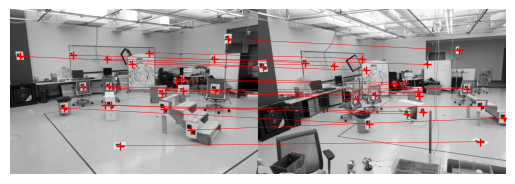

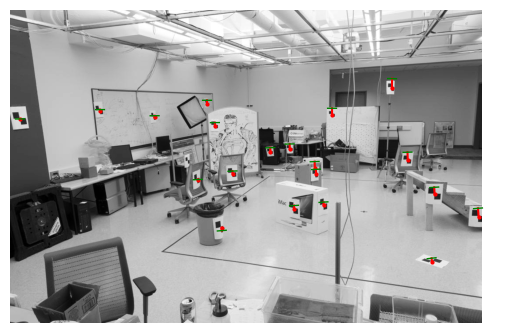

Unnormalized: 0.07460790767721817


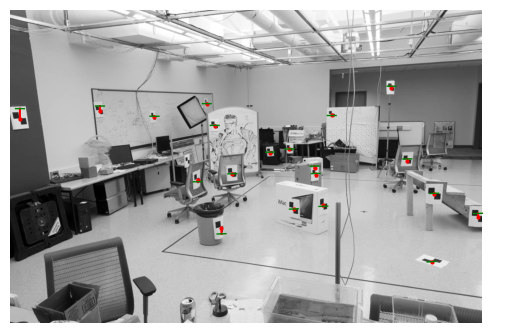

Normalized: 0.030283993934168515


In [16]:
root = ''
im_name = 'lab'  # 'house' or 'library'
im_1, im_2, matches = load_plot_data(root, im_name)

# Unnormalize.
# Use homogeneous setup.
F = fit_fundamental(matches, normalize=False, setup='non-homogeneous')
plot_epipolar(matches, F, im_2, root, im_name+'_epipolar_unnorm_nonhomo')

dist1, dist2 = get_geo_distance(matches, F)
print("Unnormalized: {}".format(dist1 + dist2))


# Normalize.
F = fit_fundamental(matches, normalize=True, setup='non-homogeneous')
plot_epipolar(matches, F, im_2, root, im_name+'_epipolar_norm_nonhomo')

dist1, dist2 = get_geo_distance(matches, F)
print("Normalized: {}".format(dist1 + dist2))


In [17]:
## Camera Calibration
def evaluate_points(M, points_2d, points_3d):
    """
    Visualize the actual 2D points and the projected 2D points calculated from
    the projection matrix
    You do not need to modify anything in this function, although you can if you
    want to
    :param M: projection matrix 3 x 4
    :param points_2d: 2D points N x 2
    :param points_3d: 3D points N x 3
    :return:
    """
    N = len(points_3d)
    points_3d = np.hstack((points_3d, np.ones((N, 1))))
    points_3d_proj = np.dot(M, points_3d.T).T
    u = points_3d_proj[:, 0] / points_3d_proj[:, 2]
    v = points_3d_proj[:, 1] / points_3d_proj[:, 2]
    residual = np.sum(np.hypot(u-points_2d[:, 0], v-points_2d[:, 1]))
    points_3d_proj = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))
    return points_3d_proj, residual

In [18]:
# calculate camera projection matrices
matches = matches
lab3d = np.loadtxt(os.path.join("lab_3d.txt"))
N = matches.shape[0]
coords_3d = np.hstack((lab3d, np.ones((N,1))))

A1 = np.empty((2*N, 12))
A2 = np.empty((2*N, 12))

for i in range(N):
    A1[2*i]   = np.hstack((np.zeros(4), coords_3d[i], -matches[i][1] * coords_3d[i]))
    A1[2*i+1] = np.hstack((coords_3d[i], np.zeros(4), -matches[i][0] * coords_3d[i]))
    A2[2*i]   = np.hstack((np.zeros(4), coords_3d[i], -matches[i][3] * coords_3d[i]))
    A2[2*i+1] = np.hstack((coords_3d[i], np.zeros(4), -matches[i][2] * coords_3d[i]))
    
u1, s1, v1 = np.linalg.svd(A1.T @ A1)
u2, s2, v2 = np.linalg.svd(A2.T @ A2)

P1_lab = v1[-1].reshape((3,4))
P2_lab = v2[-1].reshape((3,4))

projected_points_1, residual_1 = evaluate_points(P1_lab, matches[:,0:2], lab3d)
projected_points_2, residual_2 = evaluate_points(P2_lab, matches[:,2:4], lab3d)

print("Projection matrice 1: ")
print(P1_lab)
print("Projection matrice 2: ")
print(P2_lab)
print("Residual 1:")
print(residual_1)
print("Residual 2:")
print(residual_2)

Projection matrice 1: 
[[-3.09963956e-03 -1.46205031e-04  4.48498448e-04  9.78930676e-01]
 [-3.07018197e-04 -6.37193726e-04  2.77356160e-03  2.04144414e-01]
 [-1.67933507e-06 -2.74767711e-06  6.83965776e-07  1.32882926e-03]]
Projection matrice 2: 
[[-6.93154844e-03  4.01684642e-03  1.32602798e-03  8.26700542e-01]
 [-1.54768761e-03 -1.02452749e-03  7.27440828e-03  5.62523274e-01]
 [-7.60946222e-06 -3.70953978e-06  1.90203092e-06  3.38807765e-03]]
Residual 1:
13.545770830239727
Residual 2:
15.544963799332589


Residuals: 10.017098289856898, 4.069147222724494
For sanity, avg distance between triangulated 3d coords and known 3d coords: 0.07292184545894626


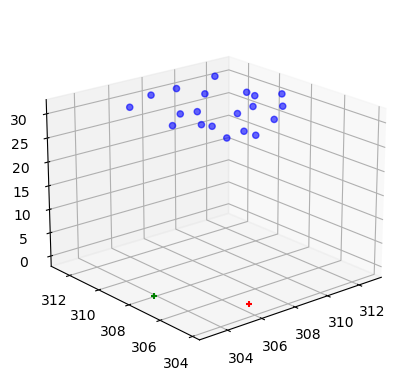

In [19]:
def D2ToD3HomoCoords(vector_2d):
    return [vector_2d[0], vector_2d[1], 1]
def toCrossMatrix(vector_3d):
    a1 = vector_3d[0]
    a2 = vector_3d[1]
    a3 = vector_3d[2]
    return [[0, -a3, a2], [a3, 0, -a1], [-a2, a1, 0]]
def D4HomoCoordsToD3(vector_4d):
    return np.array([vector_4d[0] / vector_4d[3], vector_4d[1] / vector_4d[3], vector_4d[2] / vector_4d[3]])
def D3HomoCoordsToD2(vector_3d):
    return np.array([vector_3d[0] / vector_3d[2], vector_3d[1] / vector_3d[2]])
proj_dict = {
    'lab' : (P1_lab, P2_lab),
    #'library' : (lib1_cam, lib2_cam)
}
camera_centers_dict = dict()

for loc in ['lab']:
    matches = matches
    N = matches.shape[0]
    P1, P2 = proj_dict[loc]
    u1, s1, v1 = np.linalg.svd(P1)
    u2, s2, v2 = np.linalg.svd(P2)
    n_space1 = v1[-1]
    n_space2 = v2[-1]
    camera_center_3d1 = D4HomoCoordsToD3(n_space1)
    camera_center_3d2 = D4HomoCoordsToD3(n_space2)
    camera_centers_dict[loc] = (camera_center_3d1, camera_center_3d2)
    #print("Camera center 1 for location `" + loc + "`: " + str(camera_center_3d1))
    #print("Camera center 2 for location `" + loc + "`: " + str(camera_center_3d2))
## Triangulation
true_pts = np.loadtxt(os.path.join("lab_3d.txt"))

angles_dict = {
    'lab' : (20, -130),
    'library' : (0, -90)
}

for loc in ['lab']:
    matches = matches
    N = matches.shape[0]
    P1, P2 = proj_dict[loc]
    P1_inv, P2_inv = np.linalg.pinv(P1), np.linalg.pinv(P2)
    triangulated_coords = np.empty((N,3)) # desired coordinates
    residuals_1 = 0
    residuals_2 = 0

    for i in range(N):
        p_1 = D2ToD3HomoCoords(matches[i][0:2])
        p_2 = D2ToD3HomoCoords(matches[i][2:4])
        x1_x = toCrossMatrix(p_1)
        x2_x = toCrossMatrix(p_2)
        prod_1 = x1_x@P1
        prod_2 = x2_x@P2
        U = prod_1 - prod_2
        u, s, v = np.linalg.svd(U.T@U)
        soln = v[-1]
        triangulated_coords[i] = D4HomoCoordsToD3(soln)
        # calculate 2d coordinates of triangulated point in each image
        proj_pt_1_homo = P1@soln
        proj_pt_2_homo = P2@soln
        # convert to standard 2d coordinates
        proj_pt_1 = D3HomoCoordsToD2(proj_pt_1_homo)
        proj_pt_2 = D3HomoCoordsToD2(proj_pt_2_homo)
        # calculate distance between 2d projection of triangulated 3d pt and observed points
        residuals_1 += np.linalg.norm(proj_pt_1 - matches[i][0:2])
        residuals_2 += np.linalg.norm(proj_pt_2 - matches[i][2:4])
    
    avg_residuals_1 = residuals_1 / N
    avg_residuals_2 = residuals_2 / N
    print("Residuals: {}, {}".format(avg_residuals_1, avg_residuals_2))
        
    if loc == 'lab':
        total_distance = 0
        for i in range(N):
            true_pt = true_pts[i]
            triangulated_pt = triangulated_coords[i]
            distance = np.linalg.norm(true_pt - triangulated_pt)
            total_distance += distance
        avg_distance = total_distance / N
        print("For sanity, avg distance between triangulated 3d coords and known 3d coords: " + str(avg_distance))
    
    # plotting
    xs = triangulated_coords[:,0]
    ys = triangulated_coords[:,1]
    zs = triangulated_coords[:,2]
    camera_center_1, camera_center_2 = camera_centers_dict[loc]
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    
    ax.scatter(xs, ys, zs, c='b', marker='o', alpha=0.6)
    ax.scatter(camera_center_1[0], camera_center_1[1], c='r', marker='+')
    ax.scatter(camera_center_2[0], camera_center_2[1], c='g', marker='+')
    ax.text(camera_center_1[0], camera_center_1[1], camera_center_1[2], '')
    ax.text(camera_center_2[0], camera_center_2[1], camera_center_2[2], '')
    
    ax.view_init(elev=angles_dict[loc][0], azim=angles_dict[loc][1])
    
    plt.show()
  

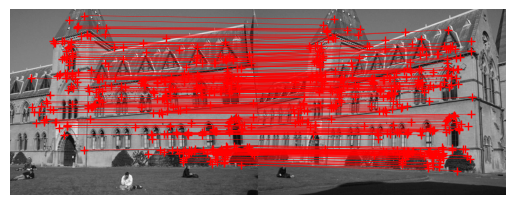

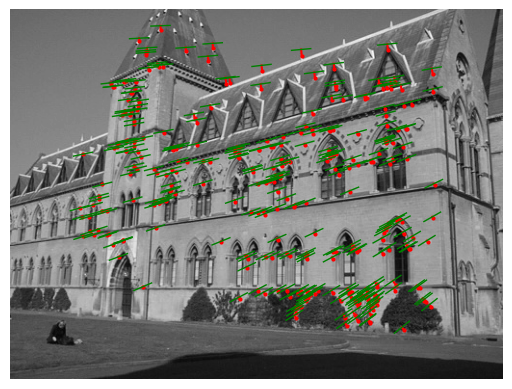

Unnormalized: 0.03049145968156545


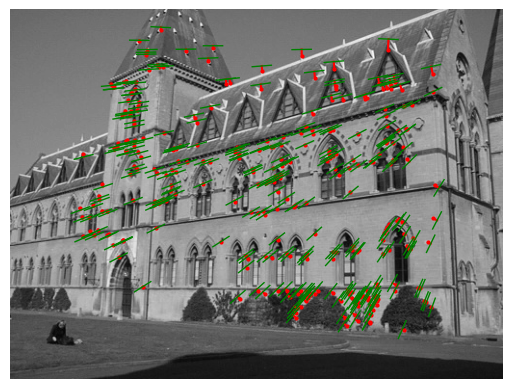

Nnormalized: 0.024947711698872718


In [20]:
root = ''
im_name = 'library'  # 'house' or 'library'
im_1, im_2, matches = load_plot_data(root, im_name)

# Unnormalize.
# Use homogeneous setup.
F = fit_fundamental(matches, normalize=False, setup='non-homogeneous')
plot_epipolar(matches, F, im_2, root, im_name+'_epipolar_unnorm_nonhomo')
dist1, dist2 = get_geo_distance(matches, F)
print("Unnormalized: {}" .format(dist1 + dist2))


# Normalize.
F = fit_fundamental(matches, normalize=True, setup='non-homogeneous')
plot_epipolar(matches, F, im_2, root, im_name+'_epipolar_norm_nonhomo')
dist1, dist2 = get_geo_distance(matches, F)
print("Nnormalized: {}" .format(dist1 + dist2))

Triangulation.
Residuals: 7.532180317017734, 10.339121174852957


/var/folders/gj/wh0hvr2s3lqgjbm2qyqh154c0000gn/T/ipykernel_60457/515869551.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)


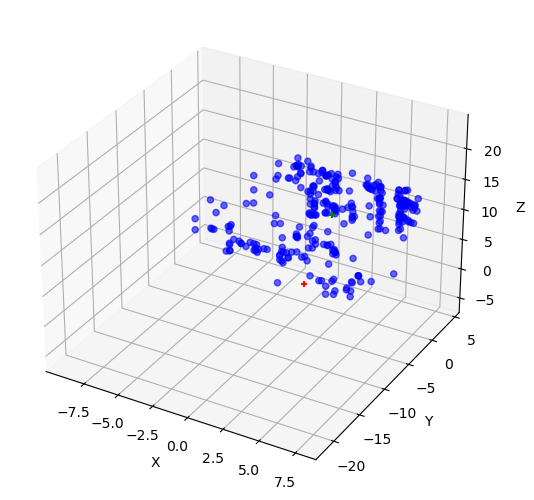

In [21]:
print("Triangulation.")
        # Load data.
camera1 = np.loadtxt(root+im_name+'1_camera.txt')
camera2 = np.loadtxt(root+im_name+'2_camera.txt')
        # Triangulation.
center1, center2, X_3D = triangulate(camera1, camera2, matches)
avg_res1, avg_res2 = get_residual(camera1, camera2, X_3D, matches)
print("Residuals: {}, {}".format(avg_res1, avg_res2))
        # Plot 3D reconstruction.
plot_3d(center1, center2, X_3D)

/Users/baby/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/baby/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Number of inliers: 78
Best F: 
[[-7.49081453e-05  5.36481952e-04 -5.73100063e-03]
 [-5.08452177e-04  6.41663811e-05  2.79684028e-01]
 [ 5.89611581e-02 -2.90269008e-01 -7.24485388e+00]]
Average residual for house: 18.296303776256668
Number of inliers: 43
Best F: 
[[-7.49081453e-05  5.36481952e-04 -5.73100063e-03]
 [-5.08452177e-04  6.41663811e-05  2.79684028e-01]
 [ 5.89611581e-02 -2.90269008e-01 -7.24485388e+00]]
Average residual for gaudi: 106.22961148214922


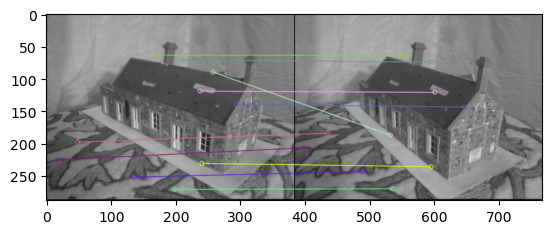

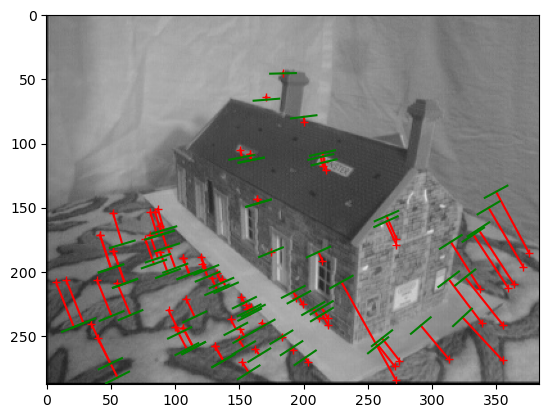

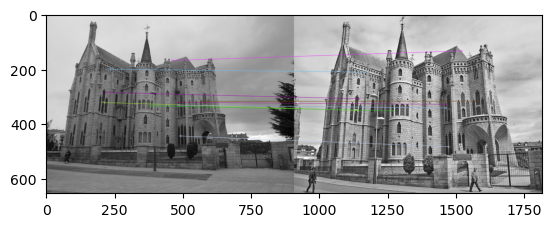

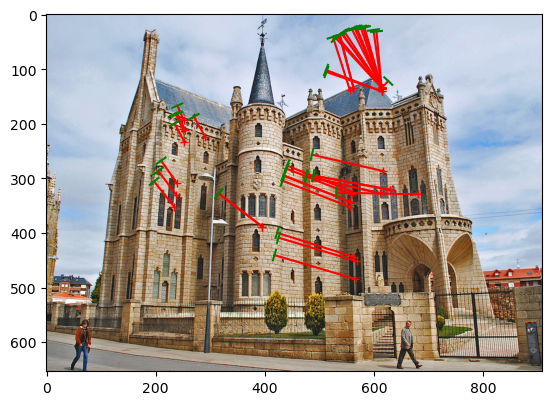

In [22]:
def plot_matches(F, match_coords, loc, image2, matches):
    N = len(match_coords)
    
    M = np.c_[match_coords[:,0:2], np.ones((N,1))].transpose()
    L1 = np.matmul(F, M).transpose() # transform points from 
    # the first image to get epipolar lines in the second image

    # find points on epipolar lines L closest to match_coords(:,2:4)
    l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
    L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
    pt_line_dist = np.multiply(L, np.c_[match_coords[:,2:4], np.ones((N,1))]).sum(axis = 1)
    closest_pt = match_coords[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())
    
    # calculate residuals
    residuals = np.mean(np.abs(pt_line_dist))
    print("Average residual for " + loc + ": " + str(residuals))

    # find endpoints of segment on epipolar line (for display purposes)
    pt1 = closest_pt - np.c_[L[:,1], -L[:,0]]*10  # offset from the closest point is 10 pixels
    pt2 = closest_pt + np.c_[L[:,1], -L[:,0]]*10

    # display points and segments of corresponding epipolar lines
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image2)
    ax.plot(match_coords[:,2],match_coords[:,3],  '+r')
    ax.plot([match_coords[:,2], closest_pt[:,0]],[match_coords[:,3], closest_pt[:,1]], 'r')

    # display segments
    ax.plot([pt1[:,0], pt2[:,0]],[pt1[:,1], pt2[:,1]], 'g')
    
    # save fig
    plt.savefig(loc + "_" + ("norm" if True else "no_norm") + ".png")
# RANSAC PARAMETERS
im_names = ["gaudi1", "gaudi2", "house1", "house2", "lab1", "lab2", "library1", "library2"]
im_paths = [os.path.join(im_name + ".jpg") for im_name in im_names]
im_array = [Image.open(im_path) for im_path in im_paths]
pair_dict = dict()
pair_dict["gaudi"]   = (im_array[0], im_array[1])
pair_dict["house"]   = (im_array[2], im_array[3])
pair_dict["lab"]     = (im_array[4], im_array[5])
pair_dict["library"] = (im_array[6], im_array[7])
N_MATCHES = 100
N_RANSAC = 3000
s = 8
THRESHOLD_DICT = {
    'gaudi' : 1.0,
    'house' : 1.0
}

def RANSAC(matches, l_kps, r_kps, loc):
    # our return values
    best_num_inliers = 0
    best_avg_inlier_residual = 0
    best_F = np.empty((3,4))
    best_inliers = []
    
    N = len(putatives)
    
    # iterate N_RANSAC times
    for i in range(N_RANSAC):
        # draw 8 matches at random 
        sampled_matches = np.array(random.sample(matches.tolist(), s))
        
        # compute F (fundamental matrix)
        F = fit_fundamental(sampled_matches)
        
        # find distances from all points and their corresponding epipolar lines
        M = np.c_[matches[:,0:2], np.ones((N,1))].transpose()
        L1 = np.matmul(F, M).transpose() # transform points from 
        # the first image to get epipolar lines in the second image

        # find points on epipolar lines L closest to matches(:,2:4)
        l = np.sqrt(L1[:,0]**2 + L1[:,1]**2)
        L = np.divide(L1,np.kron(np.ones((3,1)),l).transpose())# rescale the line
        pt_line_dist = np.multiply(L, np.c_[matches[:,2:4], np.ones((N,1))]).sum(axis = 1)
        closest_pt = matches[:,2:4] - np.multiply(L[:,0:2],np.kron(np.ones((2,1)), pt_line_dist).transpose())
        
        # get inliers
        abs_distances = np.abs(pt_line_dist)
        inlier_indices = np.where(abs_distances < THRESHOLD_DICT[loc])
        inliers = matches[inlier_indices]
        num_inliers = len(inliers)
        abs_inlier_distances = abs_distances[inlier_indices]
        
        # calculate residuals for inliers
        avg_residual = np.mean(abs_inlier_distances)
        
        # update best fundamental matrix
        if num_inliers > best_num_inliers:
            best_num_inliers = num_inliers
            best_avg_inlier_residual = avg_residual
            best_F = F
            best_inliers = inliers
    return np.array(best_inliers), best_avg_inlier_residual, best_F
for loc in ['house', 'gaudi']:
    im1_color, im2_color = pair_dict[loc]
    img1, img2 = np.asarray(im1_color.convert('L')), np.asarray(im2_color.convert('L'))

    # Initiate SIFT detector
    sift = cv2.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_L2)

    # Match descriptors.
    matches_sift = bf.match(des1, des2)

    # Sort them in the order of their distance.
    matches_sift = sorted(matches_sift, key = lambda x:x.distance)

    #print(len(matches_sift))

    # Select top N matches
    putatives = matches_sift[:N_MATCHES]

    # Draw first 10 matches.
    img3 = cv2.drawMatches(img1, kp1, img2, kp2, putatives[:10], None, flags=2)
    
    fig, ax = plt.subplots()
    ax.imshow(img3)
    
    # reformat matches
    N = len(putatives)
    
    left_pts = np.array([np.array(kp1[putatives[i].queryIdx].pt) for i in range(N)])
    right_pts = np.array([np.array(kp2[putatives[i].trainIdx].pt) for i in range(N)])
    matches = np.hstack((left_pts, right_pts))
    
    # perform RANSAC to find best F
    best_inliers, best_avg_inlier_residual, best_F = RANSAC(matches, kp1, kp2, loc)
    
    n_inliers = len(best_inliers)
    
    # statistics and visualization
    print("Number of inliers: " + str(n_inliers))
    print("Best F: ")
    print(F)

    
    plot_matches(F, best_inliers, loc, im2_color, matches)